In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
from __future__ import division
import datetime

# import the custom machine learning helper functions that are in a separate module in the same folder
import mltl

sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


#Project 2 - Predicting Large Building Energy Intensity in NYC

*Author:* Theodore Love

*Date:* March 18, 2015

Local Law 84 requires large buildings in NYC to disclose energy usage intensity (EUI is a measure of energy usage per square foot). What if we were able to predict these values based on other sources of information? Or, figure out what portion of a buildings energy usage can be explained by it's general characteristics and identify those buildings that have larger than normal unexplained energy intensity? 

This project attempts to use basic information avaiable from NYC's large collection of tax lot characteristics to see if it is possible to predict large building usage.

**Contents**
1. Overview of Data Collected in Project 1
2. Side Exploration of Housing Maintenence Code Violations
3. PLUTO
3. Combining Data Sets
4. Predicting EUI

> **NOTE:** The data sources for this project were too large for github, but a cleaned and merged version of the data used for the analysis can be found in this folder and the code to import it is located at the beginning of section 4. The code below sets the local directory where the source data is currently stored.

In [2]:
data_folder = '/Users/Theo/Dropbox (Personal)/ProgrammingProjects/GADSdata'

## 1. Overview of Data Collected in Project 1

This analysis is primarily based on data relating to [NYC Local Law 84](http://www.nyc.gov/html/gbee/html/plan/ll84.shtml), which requires private sector buildings that are larger than 50,000 square feet, and two or more private sector buildings on a single lot that are larger than 100,000 square feet, to provide annual data on energy and water consumption. Significant analysis has been done on this data set and presented in a [series of reports](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml). This analysis attempts to extend this previous work.

The original data covers five basic categories of information:
* Building Location (borough/block/lot, address, etc.)
* Building Info (building type, square footage, id, etc.)
* Energy Usage (gross kBTUs/ft2, weather normalized kBTUs/ft2, ENERGY STAR score)
* Water Usage per ft2 (along with source)
* GHG Emissions (calculated from kBtu/ft2 and a coefficient estimate)

All of this data is sourced from [NYC Open Data](https://nycopendata.socrata.com/), and has both zip code and borough/block/lot information, which makes for a good way to work in other data sets.

**Data Sets Used in Project 1**

|Name | Source |
|---| --- |
|Local Law 84 Disclosures (2011) | [Source](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/q39e-7gbs)|
|Local Law 84 Disclosures (2012 | [Source](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/5gde-fmj3)|

**Data Set for Project 2**

In order to keep this project's analysis to a more manageable scope, we will **only look at data for 2012**, which was both more comprehensive and had less issues than 2011 data. This also allows us to establish **BBL** as a a unique key (with a little bit of wrangling).

In [3]:
# import and rename columns
buildings = pd.read_csv(data_folder +  '/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2012.csv')
buildings.columns = "bbl st_no st_name borough zip bench_sub entry_no EUI EUIwn water_ft2 \
            water_method energy_star GHG floor_area property_type no_buildings reported_BINS".split()
buildings.ix[buildings['energy_star'] == 'Exempt', 'energy_star'] = np.NaN

# Remove the anomalies the same was as in Project 1
curr = len(buildings)
print "Anomalies"
print "========="
print "Starting observations: %i" % curr

buildings = buildings[pd.notnull(buildings['EUIwn'])]
print "Missing EUIwn: %i" % (curr - len(buildings))
curr = len(buildings)

buildings = buildings[buildings['EUI'] > 0]
print "EUI of 0: %i" % (curr - len(buildings))
curr = len(buildings)

buildings = buildings[buildings['EUIwn'] >= 5]
print "EUIwn < 5: %i" % (curr - len(buildings))
curr = len(buildings)

buildings = buildings[buildings['EUIwn'] <= 1000]
print "EUIwn > 1,000: %i" % (curr - len(buildings))
curr = len(buildings)

buildings = buildings[buildings['floor_area'] >= 25000]
print "floor area < 25k ft2: %i" % (curr - len(buildings))
curr = len(buildings)

buildings = buildings[pd.notnull(buildings['GHG'])]
print "Missing GHG: %i" % (curr - len(buildings))
curr = len(buildings)

print "Water per ft2 > 100: %i (kept observation)" % len(buildings[buildings['water_ft2'] > 100])  
buildings['water_ft2'] = buildings['water_ft2'].apply(lambda x: np.NaN if x > 100 else x)

# In order to make a unique list by BBL, ignore any BBLs with more than one entry
bbl_count = buildings.bbl.groupby(buildings.bbl).count()
multi_bbl = list(bbl_count[bbl_count >1].index)
buildings['multi_bbl'] = buildings.bbl.apply(lambda x: x in multi_bbl)
print "Multiple observations in a BBL: %i" % (len(buildings[buildings.multi_bbl]))
buildings = buildings[buildings.multi_bbl == False]

print "Remaining observations: %i" % len(buildings)
buildings = buildings.set_index('bbl')

Anomalies
Starting observations: 14112
Missing EUIwn: 3041
EUI of 0: 67
EUIwn < 5: 52
EUIwn > 1,000: 110
floor area < 25k ft2: 273
Missing GHG: 37
Water per ft2 > 100: 480 (kept observation)
Multiple observations in a BBL: 801
Remaining observations: 9731


##2. Side Note on Housing Maintence Code Violations

[Housing code violations](https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5) may have some predictive power for **Multifamily** buildings, and are available by BBL.

In order to make the data as relevant as possible to 2012, only violations that were observed in 2012 will be used (i.e. **InspectionDate** has the year 2012). 

The data is by unique violation, so some aggregation is necessary. Each violation has a text description, which may be interesting to examine later, but for now the pertinant field will be **OrderNumber**, which corresponds to the law which is being violated. 

After filtering and aggregating, we have a dataframe that, for each **BBL**, provides a count of violations observed in 2012 for each **OrderNumber**.

In [4]:
# import the data and create a bbl field
hmcv = pd.read_csv(data_folder + "/housing_maint_violations/Housing_Maintenance_Code_Violations.csv", low_memory=False)
hmcv['bbl'] = hmcv.BoroID.map(str) + \
              hmcv.Block.apply(lambda x: str(x).zfill(5)) + \
              hmcv.Lot.apply(lambda x: str(x).zfill(4))
hmcv.bbl = hmcv.bbl.map(int)

# convert the InspectionDate to a datetime field and extract a new column for year
hmcv.InspectionDate = pd.to_datetime(hmcv.InspectionDate)
hmcv['InspectionYear'] = hmcv.InspectionDate.apply(lambda x: x.year)

# get the count of each OrderNum by BBL in 2012 and make a sum of violations feature
hmcv_2012 = pd.pivot_table(hmcv[hmcv.InspectionYear == 2012][['bbl','OrderNumber']],
                           values=['OrderNumber'],
                           index=['bbl'],
                           columns=['OrderNumber'],
                           aggfunc=len,
                           fill_value=0)
hmcv_2012.columns = 'hmcv_num_' + hmcv_2012.columns.map(str)
hmcv_2012['violations'] = hmcv_2012.sum(axis=1)
hmcv_2012.describe()

,hmcv_num_4,hmcv_num_8,hmcv_num_84,hmcv_num_106,hmcv_num_109,hmcv_num_118,hmcv_num_176,hmcv_num_188,hmcv_num_209,hmcv_num_483,...,hmcv_num_1042,hmcv_num_1051,hmcv_num_1061,hmcv_num_1067,hmcv_num_1492,hmcv_num_1493,hmcv_num_1501,hmcv_num_1502,hmcv_num_1503,violations
count,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,...,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000,2760.000000
mean,0.002536,0.000362,0.000362,0.009783,0.002536,0.000362,0.000725,0.002174,0.000725,0.001449,...,0.008333,0.000362,0.005072,0.002174,0.000362,0.001812,0.007971,0.307246,0.165580,8.538406
std,0.063091,0.019035,0.019035,0.115390,0.073691,0.019035,0.026914,0.046583,0.026914,0.038049,...,0.143493,0.019035,0.080612,0.065914,0.019035,0.042532,0.092926,0.827108,0.552214,14.117484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
max,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000,14.000000,6.000000,293.000000


In [5]:
# merge in the housing maintenance code violations
bd = buildings.join(hmcv_2012)
print "Code Violation data merged: %i features and %i observations." % (len(bd.columns), len(bd))

# fill in the missing values with 0 and drop any columns that don't have any values
bd[list(hmcv_2012.columns)] = bd[list(hmcv_2012.columns)].fillna(0)
bd_sum = bd[list(hmcv_2012.columns)].sum()
no_violations = list(bd_sum[bd_sum == 0].index)
bd.drop(labels=no_violations, axis=1, inplace=True)

# show the count by property_type
cols = [x for x in list(hmcv_2012.columns) if x not in no_violations] + ['property_type']
group_violations = bd[cols].groupby('property_type').sum()
print "Observations with violations: %i" % len(bd[bd.violations > 0])
group_violations[group_violations.violations > 0]

Code Violation data merged: 195 features and 9731 observations.
Observations with violations: 449


,hmcv_num_106,hmcv_num_484,hmcv_num_491,hmcv_num_501,hmcv_num_502,hmcv_num_503,hmcv_num_504,hmcv_num_505,hmcv_num_506,hmcv_num_507,...,hmcv_num_765,hmcv_num_778,hmcv_num_790,hmcv_num_791,hmcv_num_807,hmcv_num_883,hmcv_num_1501,hmcv_num_1502,hmcv_num_1503,violations
property_type,,,,,,,,,,,,,,,,,,,,,
Multifamily Housing,4,3,24,383,328,1,17,125,53,47,...,1,2,55,1,1,1,1,110,57,4146
Office,0,0,1,0,1,0,1,2,0,0,...,0,0,1,0,0,0,0,0,0,29
Public Assembly,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
Residence Hall/Dormitory,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
Senior Care Facility,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


Not many buildings had violations, and almost all of them were for **Multifamily Housing**. Next we will plot the relationship and see if it has any explanatory power.

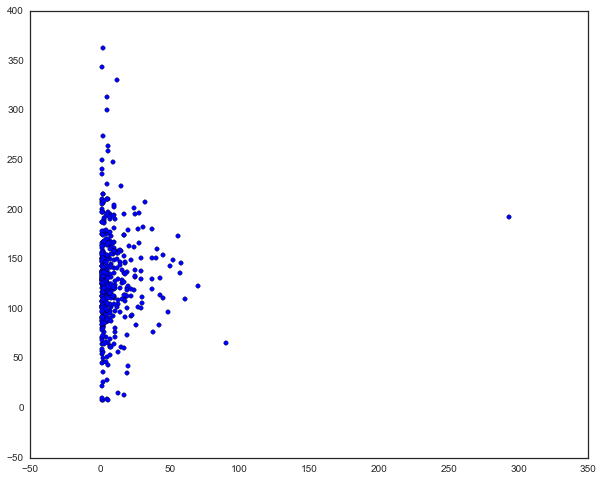

EUIwn ~ violations
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7655
Date:                Wed, 18 Mar 2015   Prob (F-statistic):              0.382
Time:                        16:13:19   Log-Likelihood:                -2382.5
No. Observations:                 449   AIC:                             4769.
Df Residuals:                     447   BIC:                             4777.
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    130.5719      2.609     50.052      0.000       125.445   135.699
violations     0.1142      0.131 

In [6]:
# plot the number of violations against the EUIwn
bd_violations = bd[bd.violations > 0 ]
plt.figure(figsize=(10, 8))
plt.subplot(111)
plt.scatter(bd_violations.violations, bd_violations.EUIwn,)
plt.show()

# show a quick regression
lm = mltl.Linear()
print lm.smf_linear(['violations'],'EUIwn', bd_violations).summary()

The graph shows some skew in **EUIwn** as violations increase, but the relaitionship is not significant even when looking just at the subset of buildings with violations. Becuase of this, the focus of the rest of the project will be on PLUTO data.

## 3. PLUTO

NYC maintains extensive land use and geographic data at the tax lot level in their Primary Land Use Tax Lot Output database ([PLUTO](http://www.nyc.gov/html/dcp/html/bytes/dwn_pluto_mappluto.shtml)). NYC maintains [historical PLUTO data](http://www.nyc.gov/html/dcp/html/bytes/archive_pluto_mappluto.shtml) back to 2002, and for this analysis, the 2012 data (v2) is used, in order to align as closely as possible with the timing of the Local Law 84 data from 2012.

In [7]:
"""
2012 PLUTO data is saved by borough, so each is imported separately and then combined
 - Skip blank line at bottom
 - Skip leading spaces
 - BBL is a unique key
"""

# Manhattan
mn = pd.read_csv(data_folder + '/nyc_pluto_12v2/mn12v2.txt', 
                 skipfooter=1,
                 engine="python",
                 skipinitialspace=True,
                 )

# Bronx
bx = pd.read_csv(data_folder + '/nyc_pluto_12v2/bx12v2.txt',
                 skipfooter=1,
                 engine="python",
                 skipinitialspace=True,
                 )

# Brooklyn
bk = pd.read_csv(data_folder + '/nyc_pluto_12v2/bk12v2.txt',
                 skipfooter=1,
                 engine="python",
                 skipinitialspace=True,
                 )

# Queens
qn = pd.read_csv(data_folder + '/nyc_pluto_12v2/qn12v2.txt',
                 skipfooter=1,
                 engine="python",
                 skipinitialspace=True,
                 )

# Staten Island
si = pd.read_csv(data_folder + '/nyc_pluto_12v2/si12v2.txt',
                 skipfooter=1,
                 engine="python",
                 skipinitialspace=True,
                 )

# Combine and set BBL as the index (already checked for uniqueness)
pluto = pd.concat([mn,bx,bk,qn,si], axis=0)
pluto.describe()

,Block,Lot,CD,Council,PolicePrct,Easements,LotArea,BldgArea,ComArea,ResArea,...,BuiltFAR,MaxAllwFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,APPBBL,PLUTOMapID
count,859324.000000,859324.000000,859324.000000,855398.000000,855388.000000,859324.000000,8.593240e+05,859324.000000,859324.000000,859324.000000,...,859324.000000,859324.000000,859324.000000,8.593240e+05,859324.000000,859324.000000,829419.000000,829419.000000,8.581930e+05,859324.000000
mean,5301.815771,125.284543,354.036419,32.030069,86.806960,0.005074,7.867791e+03,6313.022123,2228.923938,4082.527828,...,1.140965,1.446861,3.459120,3.512138e+09,8.970288,9232.698645,1006257.479815,191689.518341,3.538946e+08,1.004698
std,3695.489329,712.010049,101.004411,13.215942,29.413449,0.083615,3.703630e+05,66822.328779,59277.914889,29323.434469,...,12.595126,1.468102,1.023812,1.031994e+09,127.951807,26256.936042,32217.315934,30463.493201,1.162034e+09,0.093883
min,0.000000,0.000000,101.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000010e+09,0.000000,0.000000,913236.000000,120308.000000,0.000000e+00,1.000000
25%,2298.000000,19.000000,306.000000,22.000000,66.000000,0.000000,2.000000e+03,1440.000000,0.000000,1281.000000,...,0.480000,0.600000,3.000000,3.030790e+09,0.000000,206.000000,989615.500000,168454.000000,0.000000e+00,1.000000
50%,4803.000000,38.000000,401.000000,32.000000,102.000000,0.000000,2.513000e+03,2088.000000,0.000000,1898.000000,...,0.780000,0.900000,4.000000,4.008320e+09,0.000000,484.000000,1008653.000000,189303.000000,0.000000e+00,1.000000
75%,7456.000000,64.000000,412.000000,44.000000,111.000000,0.000000,4.000000e+03,3120.000000,0.000000,2763.000000,...,1.280000,2.000000,4.000000,4.106040e+09,0.000000,1116.000000,1028971.000000,211104.000000,0.000000e+00,1.000000
max,16350.000000,9978.000000,595.000000,51.000000,123.000000,13.000000,2.147557e+08,27600000.000000,27600000.000000,13211398.000000,...,6088.800000,15.000000,5.000000,5.080500e+09,9566.000000,157903.000000,1067277.000000,272316.000000,5.080480e+09,5.000000


##3. Combining Data Sets

**Merge in New Data**

Merge in the *PLUTO* data on **bbl**.

In [8]:
print "Buildings data: %i features and %i observations." % (len(buildings.columns), len(buildings))

# merge in the PLUTO data
bd = bd.merge(pluto, how='left', left_index=True, right_on=['BBL'])
print "PLUTO data merged: %i features and %i observations." % (len(bd.columns), len(bd))

bd = bd.set_index(bd.BBL)

Buildings data: 17 features and 9731 observations.
PLUTO data merged: 178 features and 9731 observations.


**New Variables and Relevant Feature Lists**

Create some new variables and lists for each different kind of feature that we want to explore in our supervised machine learning. Put the features in to three general categories

> **Targets**: variables to predict

> **Class Dummies**: classification columns that need to be made in to dummy columns (ignored until later)

> **Class**: classification columns that are already True/False

> **Cont**: continuous variables

In [9]:
"""
ORIGINAL DATA
"""
# original data set features that could be relevent
targets = ['EUIwn', 'EUI']
orig_class_dummies = [u'borough', u'zip', u'property_type',]
orig_class = [u'water_method']
orig_cont = [u'water_ft2', u'energy_star', u'GHG', u'floor_area', u'no_buildings',]

# normalize EUIwn
bd['EUIwn_norm'] = bd.EUIwn.apply(lambda x: (x - bd.EUIwn.min())/ (bd.EUIwn.max() - bd.EUIwn.min()))
targets.append('EUIwn_norm')

"""
PLUTO DATA
"""
# PLUTO data set features that could be relevant. 
pluto_class_dummies = [u'BldgClass', u'LandUse', u'OwnerType', u'AreaSource', u'Ext', \
                       u'ProxCode', u'IrrLotCode', u'LotType', u'BsmtCode']
pluto_class = []
pluto_cont = [u'Easements', u'LotArea', u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea', \
              u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea', \
              u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', \
              u'BldgFront', u'BldgDepth', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot', \
              u'BuiltFAR', u'MaxAllwFAR']

# Make a dummy field for if the BBL has a Landmark
bd['Landmarked'] = bd.Landmark.apply(lambda x: 0 if x == (' ' * 35) else 1)
pluto_class.append('Landmarked')

# convert BuiltCode to a dummy of 1 means year built is an estimate
bd.BuiltCode = bd.BuiltCode.apply(lambda x: 1 if x == 'E' else 0)
pluto_class.append('BuiltCode')

# convert the 9 observations with year built of 0 to the mean of year built and make BuiltCode true
bd.ix[bd.YearBuilt == 0, 'BuiltCode'] = 1
bd.ix[bd.YearBuilt == 0, 'YearBuilt'] = bd.YearBuilt.mean()
pluto_cont.append('YearBuilt')

# latest year work was done
bd['YearLastWork'] = bd[['YearBuilt','YearAlter1','YearAlter2']].max(axis=1)
pluto_cont.append('YearLastWork')

# dummy for if alterations ever occured
bd['Altered'] = (bd.YearAlter1 > 0)
pluto_class.append('Altered')

# lot area percentages
bd.ix[bd.BldgArea == 0, ['BldgArea']] = 1 # Six BBLs have an area of 0, so change to 1 for purposes of division
area_types = [u'ComArea', u'ResArea', u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea',]
for a in area_types:
    col = 'Per'+ a
    bd[col] = bd[a] / bd['BldgArea']
    pluto_cont.append(col)
    
print "Current dataset: %i features and %i observatsion." % (len(bd.columns), len(bd))

Current dataset: 190 features and 9731 observatsion.


#4. Predicting EUI

Let's see if we can predict the EUIwn based on the separate *PLUTO* data.

> **NOTE:** The code in the next cell is for importing the cleaned data set and setting the current list of features

In [3]:
# import the merged and cleaned data set from its csv
bd = pd.read_csv('buildings_clean.csv', low_memory=False)
bd = bd.set_index('BBL')

# set the various feature sets as well
targets = ['EUIwn', 'EUI', 'EUIwn_norm']
orig_class_dummies = [u'borough', u'zip', u'property_type']
orig_class = [u'water_method']
orig_cont = [u'water_ft2', u'energy_star', u'GHG', u'floor_area', u'no_buildings']
pluto_class_dummies = [u'BldgClass', u'LandUse', u'OwnerType', u'AreaSource', u'Ext', u'ProxCode', \
                       u'IrrLotCode', u'LotType', u'BsmtCode']
pluto_class = ['Landmarked', 'BuiltCode', 'Altered']
pluto_cont = [u'Easements', u'LotArea', u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea', \
              u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea', \
              u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', \
              u'BldgFront', u'BldgDepth', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot', \
              u'BuiltFAR', u'MaxAllwFAR', 'YearBuilt', 'YearLastWork', u'PerComArea', u'PerResArea', \
              u'PerOfficeArea', u'PerRetailArea', u'PerGarageArea', u'PerStrgeArea', u'PerFactryArea',\
              u'PerOtherArea']

### Target Variable: Weather-normalized Energy Usage Intensity (EUIwn)

It looks like it has some sort of log-normal distribution, but we will wait to explore that transformation until later.

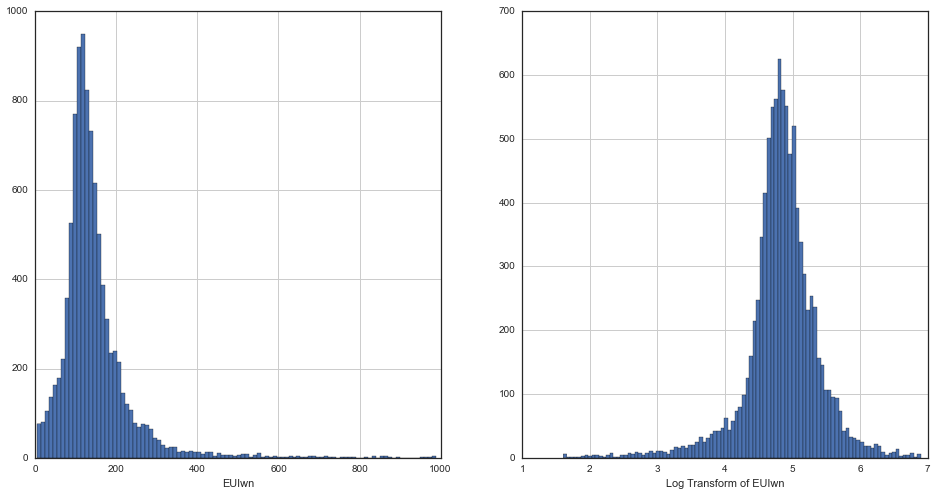

In [88]:
plt.figure(figsize=(16,8))
plt.subplot(121)
bd.EUIwn.hist(bins=100)
plt.xlabel('EUIwn')
plt.subplot(122)
log(bd.EUIwn).hist(bins=100)
plt.xlabel('Log Transform of EUIwn')

###Initial selection of Continuous Variables

Let's test out the continuous variables in a linear regression to see if anything sticks out

In [9]:
# create the X and the y
features = pluto_cont
X = bd[features]
y = bd[['EUIwn']]

# use the f_test from our linear regression helper class to see what was significant at the 95% confidence interval
lm = mltl.Linear()
linear_results = lm.f_test(X, y, ci=0.95)
print "%i of %i features passed (%0.1f percent)" % (len(linear_results), len(features), 100*len(linear_results)/len(features))
linear_results.sort('r2', ascending=False)

33 of 35 features passed (94.3 percent)


,F score,feature,p-value,r2
25,1447.930408,PerComArea,1.754402e-295,0.129546
27,1026.606002,PerOfficeArea,3.072322e-214,0.095448
26,977.448562,PerResArea,1.495496e-204,0.091295
19,869.720653,AssessTot,3.653612e-183,0.082059
18,689.249410,AssessLand,7.801710e-147,0.066158
32,635.075351,PerOtherArea,8.373825e-136,0.061277
3,634.407243,ComArea,1.146384e-135,0.061216
5,624.479377,OfficeArea,1.222770e-133,0.060316
21,459.106045,ExemptTot,1.469601e-99,0.045063
28,381.069192,PerRetailArea,2.818113e-83,0.037692


Generally we see that:
* Looks like the data on usage area by type is doing well, and taking it as a percent of the total is the best. This makes sense given that industry type should be one of the best indicators of EUI. It seems the best split is between the commercial versus residential.
* Assessed value does well, and so does exempt tax amount
* YearLastWork does better than YearBuilt (which is good)
* None of the violation data passed

Let's see where we get with a linear model looking at a selection of these values

###Make Train/Test Split

To do our supervised learning we will need a to separate the data in to a training set and testing set

In [7]:
from sklearn import cross_validation

# create one train/test split
sp = cross_validation.ShuffleSplit(len(bd), n_iter=1, test_size=0.3, random_state=3482)
for train_index, test_index in sp:
    bd_train = bd.iloc[train_index]
    bd_test = bd.iloc[test_index]

###Building Area Usage

The initial f-test results show that, as expected, it matters what the building is used for. We also see that looking at usage type as a percentage of total type seemed to have much more better effect, which frees us up to use the total **BldgArea** as a measure of amplitude. 

The main split to be expected is the one between residential and commercial, and since they are both the highest explanatory variables on their own, it probably won't help that much to add them together. The difference will probably come from looking at values that effect the extremes (perhaps storage or industrial work). 

Let's play the various building area percentage fields and the total area to see what we can come up with.

In [11]:
# start with building age data
print lm.smf_linear(['PerComArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     986.1
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          2.94e-202
Time:                        23:02:21   Log-Likelihood:                -39934.
No. Observations:                6811   AIC:                         7.987e+04
Df Residuals:                    6809   BIC:                         7.989e+04
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    124.9941      1.231    101.554      0.000       122.581   127.407
PerComArea    79.4452      2.530 

In [12]:
# check to see if building total area helps (it will probably cause multicolinearity issues)
print lm.smf_linear(['PerComArea', 'BldgArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + BldgArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     530.3
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          8.86e-215
Time:                        23:02:22   Log-Likelihood:                -39901.
No. Observations:                6811   AIC:                         7.981e+04
Df Residuals:                    6808   BIC:                         7.983e+04
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    120.8678      1.327     91.071      0.000       118.266   123.470
PerComArea    76.3803 

In [13]:
# test if residential adds any value
print lm.smf_linear(['PerComArea', 'PerResArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerResArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     493.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          6.03e-201
Time:                        23:02:23   Log-Likelihood:                -39933.
No. Observations:                6811   AIC:                         7.987e+04
Df Residuals:                    6808   BIC:                         7.989e+04
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    128.5544      3.351     38.367      0.000       121.986   135.123
PerComArea    75.959

In [14]:
# Since residential doesn't, test office
print lm.smf_linear(['PerComArea', 'PerOfficeArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     545.3
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          2.15e-220
Time:                        23:02:23   Log-Likelihood:                -39888.
No. Observations:                6811   AIC:                         7.978e+04
Df Residuals:                    6808   BIC:                         7.980e+04
Df Model:                           2                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       125.4176      1.224    102.505      0.000       123.019   127.816
PerComAr

In [15]:
# See if office and res are a better fit
print lm.smf_linear(['PerResArea', 'PerOfficeArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerResArea + PerOfficeArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     442.9
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          1.49e-181
Time:                        23:02:24   Log-Likelihood:                -39978.
No. Observations:                6811   AIC:                         7.996e+04
Df Residuals:                    6808   BIC:                         7.998e+04
Df Model:                           2                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       162.3506      2.189     74.153      0.000       158.059   166.642
PerResAr

In [16]:
# Res didn't work, so let's try adding more to commercial, first with Other
print lm.smf_linear(['PerComArea', 'PerOfficeArea', 'PerOtherArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     461.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          4.47e-273
Time:                        23:02:25   Log-Likelihood:                -39764.
No. Observations:                6811   AIC:                         7.954e+04
Df Residuals:                    6807   BIC:                         7.956e+04
Df Model:                           3                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       126.4010      1.203    105.072      0.000       124.043   1

In [17]:
# Now retail
print lm.smf_linear(['PerComArea', 'PerOfficeArea', 'PerOtherArea', 'PerRetailArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     413.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          1.60e-319
Time:                        23:02:26   Log-Likelihood:                -39653.
No. Observations:                6811   AIC:                         7.932e+04
Df Residuals:                    6806   BIC:                         7.935e+04
Df Model:                           4                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       124.7903      1.189    104.987      0.000  

In [18]:
# Storage (starting to gain less explanitory power)
print lm.smf_linear(['PerComArea', 'PerOfficeArea', 'PerOtherArea', 'PerRetailArea', 'PerStrgeArea ',],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerStrgeArea 
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     334.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          1.65e-321
Time:                        23:02:27   Log-Likelihood:                -39646.
No. Observations:                6811   AIC:                         7.930e+04
Df Residuals:                    6805   BIC:                         7.934e+04
Df Model:                           5                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       124.5842      1.189    104.

In [19]:
# Garage (starting to gain less explanitory power)
print lm.smf_linear(['PerComArea', 'PerOfficeArea', 'PerOtherArea', 'PerRetailArea', 'PerStrgeArea ', 'PerGarageArea',],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerStrgeArea  + PerGarageArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     294.5
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:28   Log-Likelihood:                -39608.
No. Observations:                6811   AIC:                         7.923e+04
Df Residuals:                    6804   BIC:                         7.928e+04
Df Model:                           6                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       123.6056   

In [20]:
# Garage throws off storage, so let's test with garage and no storage
print lm.smf_linear(['PerComArea', 'PerOfficeArea', 'PerOtherArea', 'PerRetailArea', 'PerGarageArea',],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     353.5
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:29   Log-Likelihood:                -39608.
No. Observations:                6811   AIC:                         7.923e+04
Df Residuals:                    6805   BIC:                         7.927e+04
Df Model:                           5                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       123.6057      1.187    104.

In [21]:
# That fixed it with a better R2
# Only one left to add, factory
print lm.smf_linear(['PerComArea', 'PerOfficeArea', 'PerOtherArea', 'PerRetailArea', 'PerGarageArea', 'PerFactryArea'],
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + PerFactryArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     294.6
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:30   Log-Likelihood:                -39608.
No. Observations:                6811   AIC:                         7.923e+04
Df Residuals:                    6804   BIC:                         7.928e+04
Df Model:                           6                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       123.6056   

**Conclusion**

Best combination of usage by area is:
* PerComArea 
* PerOfficeArea 
* PerOtherArea
* PerRetailArea
* PerGarageArea

Decent explanitory power with an R^2 of 0.227 and no red flags regarding multicolinearity.

### Building Age

We had two variables that looked good, so let's see how they do

In [22]:
# Start with comparing the two
print lm.smf_linear(['YearBuilt',],
                    'EUIwn', bd_train).summary()
print lm.smf_linear(['YearLastWork',],
                    'EUIwn', bd_train).summary()
print lm.smf_linear(['YearLastWork', 'YearBuilt'],
                    'EUIwn', bd_train).summary()

EUIwn ~ YearBuilt
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     163.8
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           4.39e-37
Time:                        23:02:32   Log-Likelihood:                -40313.
No. Observations:                6811   AIC:                         8.063e+04
Df Residuals:                    6809   BIC:                         8.064e+04
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -803.5411     74.198    -10.830      0.000      -948.992  -658.090
YearBuilt      0.4876      0.038  

**Conclusion**

Stick to YearLastWork since it has better explanatory power and combining the two would give multicolinearity issues.

### Lot Value

We have a few variables to look at regarding lot values, including:
* AssessTot 
* AssessLand 
* ExemptTot 
* ExemptLand

Let's work through the combos that make sense to avoid multi-colinearity

In [23]:
# Start with comparing four
print lm.smf_linear(['AssessTot',],
                    'EUIwn', bd_train).summary()
print lm.smf_linear(['AssessLand',],
                    'EUIwn', bd_train).summary()
print lm.smf_linear(['ExemptTot',],
                    'EUIwn', bd_train).summary()
print lm.smf_linear(['ExemptLand',],
                    'EUIwn', bd_train).summary()

EUIwn ~ AssessTot
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     551.3
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          2.67e-117
Time:                        23:02:34   Log-Likelihood:                -40129.
No. Observations:                6811   AIC:                         8.026e+04
Df Residuals:                    6809   BIC:                         8.028e+04
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    136.1687      1.142    119.194      0.000       133.929   138.408
AssessTot   9.481e-07   4.04e-08  

In [24]:
# we don't expect the assesed total and assessed land combined to help much
print "ASSESS"
print lm.smf_linear(['AssessTot', 'AssessLand',],
                    'EUIwn', bd_train).summary()

print "\nEXEMPT"
# and same with exempt
print lm.smf_linear(['AssessTot', 'AssessLand',],
                    'EUIwn', bd_train).summary()

ASSESS
EUIwn ~ AssessTot + AssessLand
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     276.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          2.91e-116
Time:                        23:02:34   Log-Likelihood:                -40128.
No. Observations:                6811   AIC:                         8.026e+04
Df Residuals:                    6808   BIC:                         8.028e+04
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    136.1500      1.142    119.178      0.000       133.911   138.390
AssessTot   8.

In [25]:
# but a combination with the exmept values could help
print lm.smf_linear(['AssessTot', 'ExemptTot',],
                    'EUIwn', bd_train).summary()
print lm.smf_linear(['AssessTot', 'ExemptLand',],
                    'EUIwn', bd_train).summary()

EUIwn ~ AssessTot + ExemptTot
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     289.0
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          3.46e-121
Time:                        23:02:35   Log-Likelihood:                -40117.
No. Observations:                6811   AIC:                         8.024e+04
Df Residuals:                    6808   BIC:                         8.026e+04
Df Model:                           2                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    136.2719      1.141    119.472      0.000       134.036   138.508
AssessTot   8.243e-07 

**Conclusion**

Combine the Assessed Total and Exempt Total to get the best results. Although all the data for this has some troubling multicolinearity flags.

### Initial Combination

Let's combine a few of these different variables that we explored to see if we can get a better model

In [26]:
lot_value_features = ['AssessTot', 'ExemptTot',]
building_area_features = ['PerComArea', 'PerOfficeArea', 'PerOtherArea', 'PerRetailArea', 'PerGarageArea',]
building_age_features = ['YearLastWork']

In [27]:
# combine building area with value
print lm.smf_linear(lot_value_features + building_area_features,
                    'EUIwn', bd_train).summary()

EUIwn ~ AssessTot + ExemptTot + PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     286.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:37   Log-Likelihood:                -39514.
No. Observations:                6811   AIC:                         7.904e+04
Df Residuals:                    6803   BIC:                         7.910e+04
Df Model:                           7                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       120

In [28]:
# combine building area with age
print lm.smf_linear(building_age_features + building_area_features,
                    'EUIwn', bd_train).summary()

EUIwn ~ YearLastWork + PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     311.1
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:38   Log-Likelihood:                -39569.
No. Observations:                6811   AIC:                         7.915e+04
Df Residuals:                    6804   BIC:                         7.920e+04
Df Model:                           6                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept      -467.7532    

In [29]:
# combine building age with lot value
print lm.smf_linear(building_age_features + lot_value_features,
                    'EUIwn', bd_train).summary()

EUIwn ~ YearLastWork + AssessTot + ExemptTot
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     238.3
Date:                Wed, 18 Mar 2015   Prob (F-statistic):          5.11e-147
Time:                        23:02:38   Log-Likelihood:                -40054.
No. Observations:                6811   AIC:                         8.012e+04
Df Residuals:                    6807   BIC:                         8.014e+04
Df Model:                           3                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     -661.2292     70.996     -9.314      0.000      -800.403  -522.055
Y

In [30]:
# combine all three
print lm.smf_linear(building_age_features + lot_value_features + building_area_features,
                    'EUIwn', bd_train).summary()

EUIwn ~ YearLastWork + AssessTot + ExemptTot + PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     259.3
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:39   Log-Likelihood:                -39488.
No. Observations:                6811   AIC:                         7.899e+04
Df Residuals:                    6802   BIC:                         7.906e+04
Df Model:                           8                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Inte

**Conclusion**

The age and lot value characteristics add some explanatory power to the usage values, but at the expense of some additional multicoliniearity flags. Perhaps we can improve the regression with other fields.

### Adding other variables

In [31]:
other_fields = ['Easements',
 'NumBldgs',
 'NumFloors',
 'UnitsRes',
 'UnitsTotal',
 'LotFront',
 'LotDepth',
 'BldgFront',
 'BldgDepth',
 'MaxAllwFAR',]

for f in other_fields:
    print '#\n%s\n#' % f
    print lm.smf_linear(building_area_features + [f],
                    'EUIwn', bd_train).summary()

#
Easements
#
EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     297.6
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:41   Log-Likelihood:                -39601.
No. Observations:                6811   AIC:                         7.922e+04
Df Residuals:                    6804   BIC:                         7.926e+04
Df Model:                           6                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       1

In [32]:
# no warnings with the following and a small increase in R2
best_continuous_features = building_area_features + "Easements NumBldgs NumFloors MaxAllwFAR".split()
print lm.smf_linear(best_continuous_features,
                    'EUIwn', bd_train).summary()


EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + MaxAllwFAR
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     212.6
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:43   Log-Likelihood:                -39550.
No. Observations:                6811   AIC:                         7.912e+04
Df Residuals:                    6801   BIC:                         7.919e+04
Df Model:                           9                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------

**Conclusion**

Adding the following fields to the regression helps slightly and doesn't raise any immediate data issues:
* Easements
* NumBldgs
* NumFloors
* MaxAllwFAR

### A Few Dummies

We have a few dummies built in before we ge too heavy on the categorical features that need to be transformed in to dummies. Let's check to see if these have any relevance.

In [33]:
print lm.smf_linear(pluto_class,
                    'EUIwn', bd_train).summary()

EUIwn ~ Landmarked + BuiltCode + Altered
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     24.76
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           6.30e-16
Time:                        23:02:44   Log-Likelihood:                -40357.
No. Observations:                6811   AIC:                         8.072e+04
Df Residuals:                    6807   BIC:                         8.075e+04
Df Model:                           3                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept         141.9816      1.363    104.189      0.000       139.310   144.

In [34]:
# Not much explanatory power, but still signficant
# Adding in to the best previous model doesn't help though
best_dummies = ['Altered', 'Landmarked', 'BuiltCode']
print lm.smf_linear(best_continuous_features + best_dummies,
                    'EUIwn', bd_train).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + MaxAllwFAR + Altered + Landmarked + BuiltCode
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     159.4
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:45   Log-Likelihood:                -39550.
No. Observations:                6811   AIC:                         7.913e+04
Df Residuals:                    6798   BIC:                         7.921e+04
Df Model:                          12                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------

## Current Best Model

> EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + MaxAllwFAR

### Playing with Categorical Values

We have a number of fields that have categorical data in them and are just begging to be made in to dummy variables!

In [35]:
# will start by looking at the BldgClass category from PLUTO
X = pd.get_dummies(bd_train[pluto_class_dummies[0]])

# do a quick f_regression test and sort the results by r2
results2 = lm.f_test(X, bd_train[['EUIwn']])
results2.sort('r2', ascending=False)

,F score,feature,p-value,r2
21,571.372927,I1,2.510845e-121,0.077418
5,191.678506,D4,5.212605e-43,0.027380
25,175.351639,I9,1.541575e-39,0.025106
24,144.436901,I6,6.132530e-33,0.020772
41,136.758885,O4,2.707869e-31,0.019690
3,126.810120,D1,3.696629e-29,0.018283
32,120.337018,K6,9.106772e-28,0.017366
28,118.159728,J6,2.678256e-27,0.017057
40,106.940559,O3,7.004736e-25,0.015463
48,77.601177,P7,1.579225e-18,0.011268


In [36]:
# first value helps out a bunch
print lm.smf_linear(best_continuous_features + ['I1', 'I9', 'D4', 'K6', 'D1'],
                    'EUIwn', bd_train.join(X)).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + MaxAllwFAR + I1 + I9 + D4 + K6 + D1
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:48   Log-Likelihood:                -39210.
No. Observations:                6811   AIC:                         7.845e+04
Df Residuals:                    6796   BIC:                         7.855e+04
Df Model:                          14                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------

In [37]:
# 03 not so much
print lm.smf_linear(best_continuous_features + ['I1', 'I9', 'D4', 'K6', 'D1', 'O3'],
                    'EUIwn', bd_train.join(X)).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + MaxAllwFAR + I1 + I9 + D4 + K6 + D1 + O3
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     188.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:49   Log-Likelihood:                -39209.
No. Observations:                6811   AIC:                         7.845e+04
Df Residuals:                    6795   BIC:                         7.856e+04
Df Model:                          15                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------

In [38]:
# I6 helps and really makes the MaxAllwFAR variable no longer significant
print lm.smf_linear(best_continuous_features + ['I1', 'I9', 'D4', 'K6', 'D1', 'I6'],
                    'EUIwn', bd_train.join(X)).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + MaxAllwFAR + I1 + I9 + D4 + K6 + D1 + I6
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     195.5
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:49   Log-Likelihood:                -39173.
No. Observations:                6811   AIC:                         7.838e+04
Df Residuals:                    6795   BIC:                         7.849e+04
Df Model:                          15                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------

In [39]:
# eventually these dummies make the commercial area value no longer have significance
curr_features = ['PerComArea',
 'PerOfficeArea',
 'PerOtherArea',
 'PerRetailArea',
 'PerGarageArea',
 'Easements',
 'NumBldgs',
 'NumFloors',]
curr_features = curr_features + ['I1', 'I9', 'D4', 'K6', 'D1', 'I6', 'K1', 'J6',  'P7',
 'R5',
 'E7',
 'H2',
 'K9',
 'F2',
 'I5',
 'H3',
 'W6',
 'H1',
 'H5',
 'O1',
 'E1',
 'F1',
 'H9',
 'E9',
 'J8',
 'O6',
 'G1',]

# 03 not so much
print lm.smf_linear(curr_features,
                    'EUIwn', bd_train.join(X)).summary()

EUIwn ~ PerComArea + PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + I1 + I9 + D4 + K6 + D1 + I6 + K1 + J6 + P7 + R5 + E7 + H2 + K9 + F2 + I5 + H3 + W6 + H1 + H5 + O1 + E1 + F1 + H9 + E9 + J8 + O6 + G1
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     109.1
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:50   Log-Likelihood:                -38872.
No. Observations:                6811   AIC:                         7.782e+04
Df Residuals:                    6775   BIC:                         7.806e+04
Df Model:                          35                                         
                    coef    std err  

In [40]:
# adding the rest of the dummies and removing any of them that is no longer signficant also makes the NumBldgs no longer matter
curr_features = ['PerOfficeArea',
 'PerOtherArea',
 'PerRetailArea',
 'PerGarageArea',
 'Easements',
 'NumBldgs',
 'NumFloors',]
curr_features = curr_features + ['I1', 'I9', 'D4', 'K6', 'D1', 'I6', 'K1', 'J6',  'P7',
 'R5',
 'E7',
 'H2',
 'K9',
 'F2',
 'I5',
 'H3',
 'W6',
 'H1',
 'H5',
 'O1',
 'E1',
 'F1',
 'H9',
 'E9',
 'J8',
 'O6',
 'G1',
 'F9',
 'J4',
 'K2',
 'I2',
 'F4',
 'P5',
 'N2',
 'D0',
 'L1',
 'W5',
 'P6',
 'E3',
 'W7',
 'C6',
 'J5',
 'P3',]

# 03 not so much
print lm.smf_linear(curr_features,
                    'EUIwn', bd_train.join(X)).summary()

EUIwn ~ PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + I1 + I9 + D4 + K6 + D1 + I6 + K1 + J6 + P7 + R5 + E7 + H2 + K9 + F2 + I5 + H3 + W6 + H1 + H5 + O1 + E1 + F1 + H9 + E9 + J8 + O6 + G1 + F9 + J4 + K2 + I2 + F4 + P5 + N2 + D0 + L1 + W5 + P6 + E3 + W7 + C6 + J5 + P3
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     80.95
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:02:52   Log-Likelihood:                -38797.
No. Observations:                6811   AIC:                         7.770e+04
Df Residuals:                    6760   BIC:                         7.804e+04
Df Model:                          50            

In [41]:
# adding the rest of the dummies and removing any of them that is no longer signficant also makes the NumBldgs no longer matter
curr_features = ['PerOfficeArea',
 'PerOtherArea',
 'PerRetailArea',
 'PerGarageArea',
 'Easements',
 #'NumBldgs',
 'NumFloors',]
curr_features = curr_features + ['I1', 'I9', 'D4', 'K6', 'D1', 'I6', 'K1', 'J6',  'P7',
 'R5',
 'E7',
 'H2',
 'K9',
 'F2',
 'I5',
 'H3',
 'W6',
 'H1',
 'H5',
 'O1',
 'E1',
 'F1',
 'H9',
 'E9',
 'J8',
 'O6',
 'G1',
 'F9',
 'J4',
 'K2',
 'I2',
 'F4',
 'P5',
 'N2',
 'D0',
 'I3',
 'L1',
 'W5',
 'P6',
 'E3',
 'W7',
 'C6',
 'J5',
 'P3',]

# 03 not so much
for i in range(1, len(curr_features)+1):
    print lm.smf_linear(curr_features[0:i],
                    'EUIwn', bd_train.join(X)], axis=1)).summary()

SyntaxError: invalid syntax (<ipython-input-41-7bccaf41c102>, line 49)

###The best regression so far before we start to have multicolinearity issues

In [44]:
# The best regression so far before we start to have multicolinearity issues
continuous_features = ['PerOfficeArea',
                       'PerOtherArea',
                       'PerRetailArea',
                       'PerGarageArea',
                       'Easements',
                       'NumFloors',]

dummies = ['I1', 'I9', 'D4', 'K6', 'D1', 'I6', 'K1', 'J6', 'P7', 'R5', 'E7', 'H2',\
           'K9', 'F2', 'I5', 'H3', 'W6', 'H1', 'H5', 'O1', 'E1', 'F1', 'H9', 'E9',\
           'J8', 'O6', 'G1', 'F9']

best_reg = lm.smf_linear(continuous_features + dummies,'EUIwn',bd_train.join(X))

print best_reg.summary()

EUIwn ~ PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumFloors + I1 + I9 + D4 + K6 + D1 + I6 + K1 + J6 + P7 + R5 + E7 + H2 + K9 + F2 + I5 + H3 + W6 + H1 + H5 + O1 + E1 + F1 + H9 + E9 + J8 + O6 + G1 + F9
                            OLS Regression Results                            
Dep. Variable:                  EUIwn   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     111.5
Date:                Wed, 18 Mar 2015   Prob (F-statistic):               0.00
Time:                        23:14:04   Log-Likelihood:                -38881.
No. Observations:                6811   AIC:                         7.783e+04
Df Residuals:                    6776   BIC:                         7.807e+04
Df Model:                          34                                         
                    coef    std err          t      P>|t

### A Quick Sanity Check

Let's first plot the residuals against the target variable to see where the model is not doing so well, and to make sure that we are improving between the continuous variable model and the continuous plus building class dummies. 

EUIwn ~ PerOfficeArea + PerOtherArea + PerRetailArea + PerGarageArea + Easements + NumBldgs + NumFloors + YearLastWork


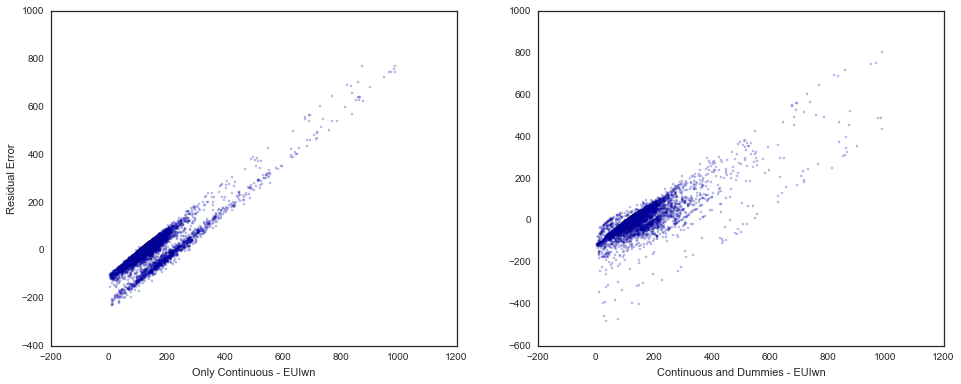

In [66]:
# recreate the regression from before including the building class dummies
prev_features = ['PerOfficeArea','PerOtherArea','PerRetailArea','PerGarageArea','Easements','NumBldgs',\
                 'NumFloors','YearLastWork',]
old_reg = lm.smf_linear(prev_features, 'EUIwn', bd_train)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(bd_train[['EUIwn']],old_reg.resid, alpha=0.25, marker='.')
plt.ylabel('Residual Error')
plt.xlabel('Only Continuous - EUIwn')
plt.subplot(122)
plt.scatter(bd_train[['EUIwn']],best_reg.resid, alpha=0.25, marker='.')
plt.xlabel('Continuous and Dummies - EUIwn')
plt.show()

Both residuals show a very clear linear trend. The first regression hadtwo clearly defined groups, while the second model spread the error out more. In general, the second model does look like an improvement over the first, but more analysisneeds to be done.

Let's do a quick cross validation to make sure that our trainign data was not accidentily biased.

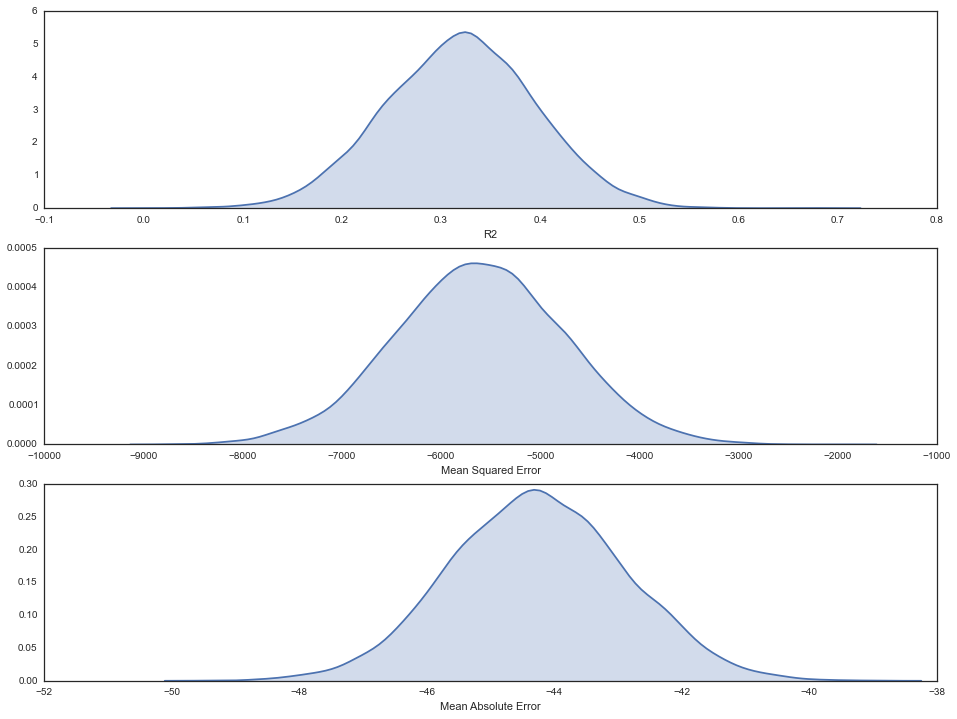

In [85]:
# add in the dummies and run the cross validation using 10 folds
full_train = bd_train.join(X)
scores = lm.cval(full_train[continuous_features + dummies], bd_train[['EUIwn']])

# plot the resulting score distributions
plt.figure(figsize=(16,12))
plt.subplot(311)
sns.kdeplot(np.random.normal(loc=np.array(scores['r2']).mean(),
                             scale=np.array(scores['r2']).std(),
                             size=10000), shade=True)
plt.xlabel('R2')
plt.subplot(312)
sns.kdeplot(np.random.normal(loc=np.array(scores['mean_squared_error']).mean(),
                             scale=np.array(scores['mean_squared_error']).std(),
                             size=10000), shade=True)
plt.xlabel('Mean Squared Error')
plt.subplot(313)
sns.kdeplot(np.random.normal(loc=np.array(scores['mean_absolute_error']).mean(),
                             scale=np.array(scores['mean_absolute_error']).std(),
                             size=10000), shade=True)
plt.xlabel('Mean Absolute Error')


A little broader distribution than I would have liked to see on the cross-validation, but we definitely still have explanitory power, so let's see how our generalized model does on our test set.

In [90]:
from sklearn import metrics
X_test = bd_test[continuous_features].join(pd.get_dummies(bd_test[pluto_class_dummies[0]]))
y_test = bd_test[['EUIwn']]

# test data does not have two classifications in our train
X_test['H5'] = [0]*len(X_test)
X_test['J8'] = [0]*len(X_test)

metrics.r2_score(y_test, best_reg.predict(X_test[continuous_features + dummies]))

0.32522729109875204

## 5. Conclusion

We are starting to get some explanatory power, but there is definitely more work to be done. Probably worth exploring the rest of the classification variables, and using a tree regression to get some idea of which variables to focus on. Also a good out of sample test would be to see how the final regression does on the 2011 data.